In [1]:
# https://github.com/nugaeun/2024_network_final_project

#(0) module import

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math

#(1) ER 네트워크에서의 보터 모델

In [3]:
# ER graph 생성
def ER_Graph(num_nodes, p):
  G = nx.Graph()
  nodes = list(range(num_nodes))
  G.add_nodes_from(nodes)

  # 노드 쌍에 대해 확률적으로 엣지 추가
  for i in nodes:
    for j in nodes:
      if i < j:  # 중복 방지
        if random.random() < p:  # 확률 p로 엣지 추가
          G.add_edge(i, j)
  return G

In [4]:
# 초기 상태 설정 (0 또는 1)
def initialize_states(G):
  num_nodes = len(G.nodes)  # 총 노드 수
  num_zeros = int(num_nodes * 0.9)  # 상태 0인 노드의 개수 (10%)
  num_ones = num_nodes - num_zeros  # 상태 1인 노드의 개수 (90%)

  # 상태 리스트 생성
  states_list = [0] * num_zeros + [1] * num_ones
  random.shuffle(states_list)  # 상태를 무작위로 섞음

  # 노드에 상태 할당
  states = {node: states_list[i] for i, node in enumerate(G.nodes)}
  nx.set_node_attributes(G, states, "state")
  return states


In [5]:
# 상태 업데이트
def update_state(G):
  node = random.choice(list(G.nodes))  # 무작위 노드 선택
  neighbors = list(G.neighbors(node))  # 이웃 리스트
  if neighbors:  # 이웃이 있는 경우
    neighbor = random.choice(neighbors)  # 무작위 이웃 선택
    G.nodes[node]["state"] = G.nodes[neighbor]["state"]  # 이웃의 상태 복사

In [14]:
def plot_snapshots(G, pos, interval, itermax):
  steps = list(range(0, itermax + 1, interval))  # 스냅샷 스텝
  fig, axes = plt.subplots(1, len(steps), figsize=(50, 5))
  history = []  # 평균 상태 기록
  time_steps = []  # 각 스텝 기록

  for step in range(itermax + 1):
    # 상태 기록 (업데이트 여부와 관계없이 기록)
    current_state = np.mean([G.nodes[i]['state'] for i in range(len(G.nodes()))])
    history.append(current_state)
    time_steps.append(step)

    # 0.1 확률로 상태 업데이트
    if random.random() <= 0.1:
      update_state(G)

    # 모든 상태가 동일한지 확인
    states = nx.get_node_attributes(G, "state")
    unique_states = set(states.values())
    if len(unique_states) == 1:  # 모든 노드 상태가 동일한 경우
      print(f"Consensus reached at step {step}")
      break

    # 스냅샷 그리기
    if step in steps:
      states = nx.get_node_attributes(G, "state")
      colors = ["blue" if state == 0 else "red" for state in states.values()]
      ax_index = steps.index(step)  # 현재 스냅샷의 인덱스
      nx.draw(
          G, pos, node_color=colors, with_labels=False, node_size=50,
          ax=axes[ax_index], edge_color='gray', alpha=0.5
      )
      axes[ax_index].set_title(f"Step {step}")

  plt.tight_layout()
  plt.show()

  # 평균 상태 변화 그래프
  plt.figure(figsize=(10, 5))
  plt.plot(time_steps, history, label="Average State")
  plt.xlabel("Time Steps")
  plt.ylabel("Average State (0 to 1)")
  plt.title("Average Node State Over Time")
  plt.legend()
  plt.grid(True)
  plt.show()


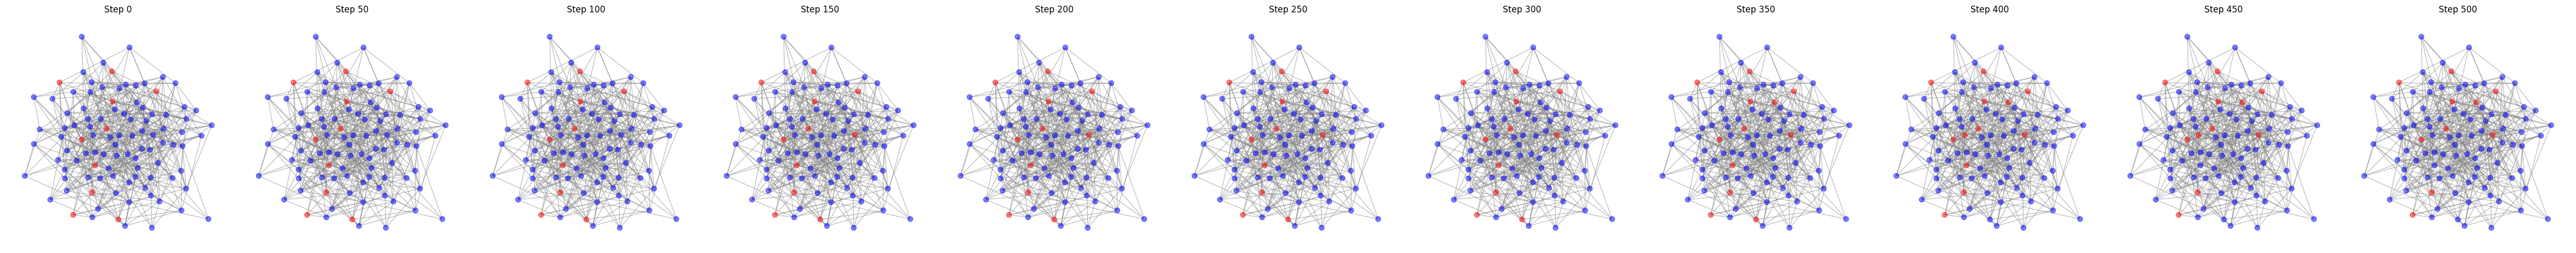

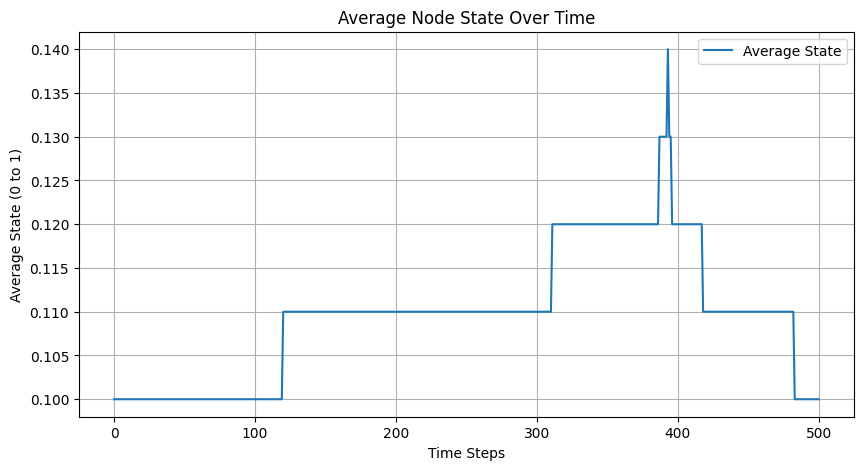

In [18]:
# 실행 부분
num_nodes = 100
p = 0.1
interval = 50  # 상태 업데이트 간격
itermax = 500  # 최대 반복 횟수

G = ER_Graph(num_nodes, p)  # 직접 그래프 생성
initialize_states(G)
pos = nx.spring_layout(G)  # 그래프 레이아웃 (미리 계산)

plot_snapshots(G, pos, interval=interval, itermax=itermax)

#(2) ER 네트워크의 이웃수분포 + 포아송

<ipython-input-19-380936191c27>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'ro-', label='Poisson Fit',color='dodgerblue')


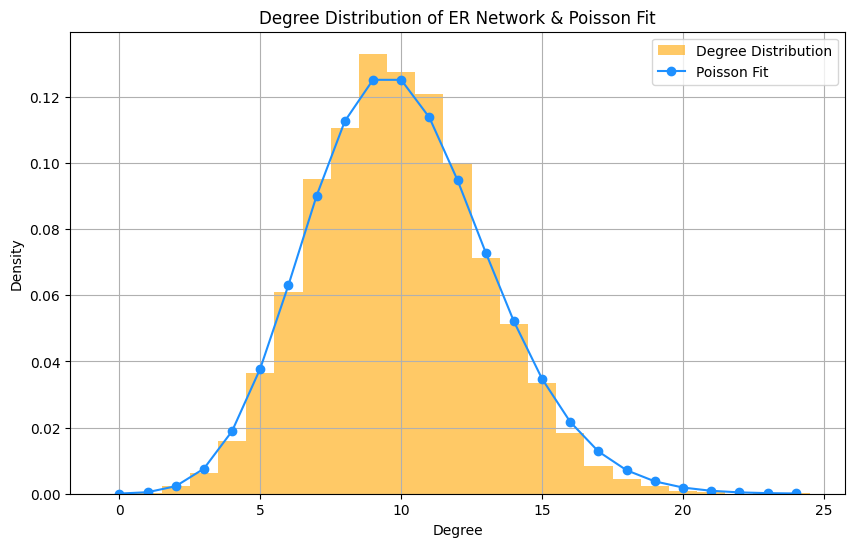

In [19]:
# ER 네트워크 생성 및 이웃 수 수집
N = 100  # 노드 수
p = 0.1  # 연결 확률
ensemble_size = 100  # 앙상블 크기

degree_counts = []

for _ in range(ensemble_size):
  G = ER_Graph(N, p)
  degrees = [degree for _, degree in G.degree()]
  degree_counts.extend(degrees)

# 평균 차수 계산
mean_degree = np.mean(degree_counts)

# 히스토그램 플롯
plt.figure(figsize=(10, 6))
bins = np.arange(0, max(degree_counts) + 1.5) - 0.5
plt.hist(degree_counts, bins=bins, density=True, alpha=0.6, color='orange', label='Degree Distribution')

# 포아송 분포 피팅
def poisson_pmf(k, lambda_):
  return (lambda_**k / math.factorial(k)) * math.exp(-lambda_)

lambda_ = N * p
x = np.arange(0, max(degree_counts) + 1)
y = [poisson_pmf(k, lambda_) for k in x]
plt.plot(x, y, 'ro-', label='Poisson Fit',color='dodgerblue')

# 플롯 설정
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Degree Distribution of ER Network & Poisson Fit')
plt.legend()
plt.grid(True)
plt.show()


#(3) ER 네트워크의 mean geodesic distance

In [20]:
def average_shortest_path_length(G) :
  total_distance = 0
  path_count = 0

  nodes = list(G.nodes()) # 모든 노드를 리스트로 저장
  for i,source in enumerate (nodes) :
    for target in nodes [i+ 1:]: # 중복 계산 방지를 위해 타겟을 이후 노드부터만 탐색
      if nx.has_path(G, source, target): # source에서 target으로의 경로가 있을 때만
        path_length = nx.shortest_path_length(G, source, target)
        total_distance += path_length
        path_count += 1

  # 평균 거리 계산
  if path_count > 0:
    return total_distance / path_count
  else:
    return 0

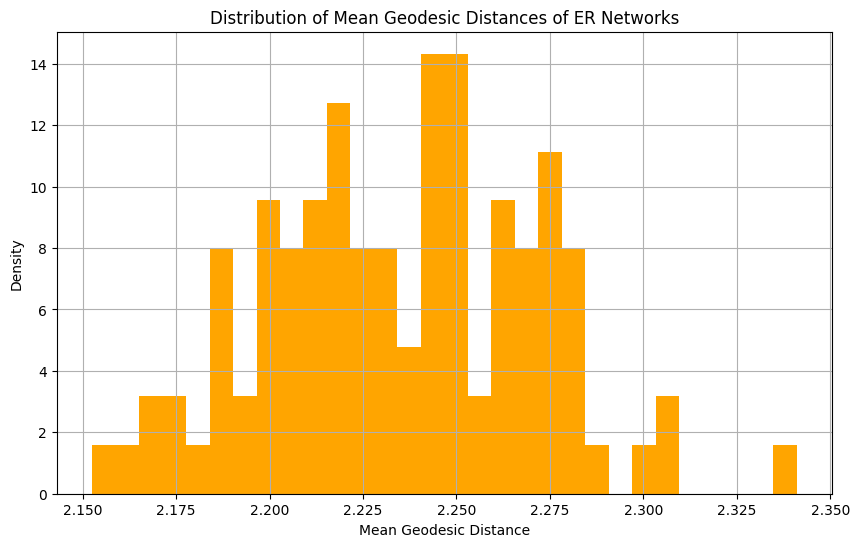

In [21]:
# 파라미터 설정
N = 100  # 노드 수
ensemble_size = 100  # 앙상블 크기
mean_geodesic_distances = []

# ER 네트워크 생성 및 평균 지오데식 거리 계산
for _ in range(ensemble_size):
    G = nx.erdos_renyi_graph(N, p=0.1)
    if nx.is_connected(G):
        mean_distance = average_shortest_path_length(G)
    else:
        mean_distance = float('inf')
    mean_geodesic_distances.append(mean_distance)

# 평균 지오데식 거리 분포 플롯
plt.figure(figsize=(10, 6))
plt.hist(mean_geodesic_distances, bins=30, density=True, label='density',color='orange')
plt.xlabel('Mean Geodesic Distance')
plt.ylabel('Density')
plt.title('Distribution of Mean Geodesic Distances of ER Networks')
plt.grid(True)
plt.show()


#(4) ER 네트워크에서 p에 따른 giant component

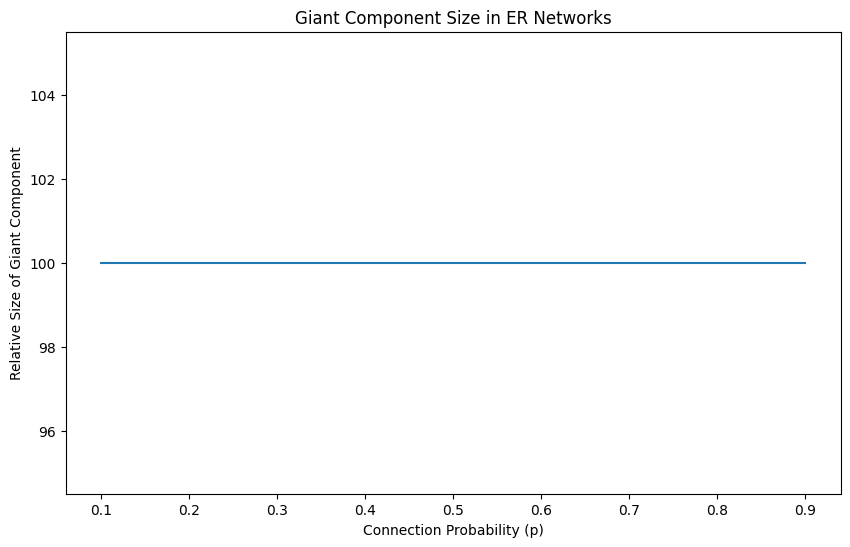

In [22]:
def er_giant_component_size(N=100, ensemble=100):
  p_values = np.arange(0.1, 1.0, 0.1)
  giant_sizes = []

  for p in p_values:
    sizes = 0
    G = ER_Graph(N, p)
    for _ in range(ensemble):
      largest_cc = max(nx.connected_components(G), key=len)
      sizes += len(largest_cc)
    giant_sizes.append(sizes/ensemble)

  plt.figure(figsize=(10, 6))
  plt.plot(p_values, giant_sizes)
  plt.xlabel('Connection Probability (p)')
  plt.ylabel('Relative Size of Giant Component')
  plt.title('Giant Component Size in ER Networks')
  plt.show()

er_giant_component_size()

#### 교수님이 명시하신대로 0.1씩 증가시키니 변화가 보이지 않아서 임의로 p값을 조절

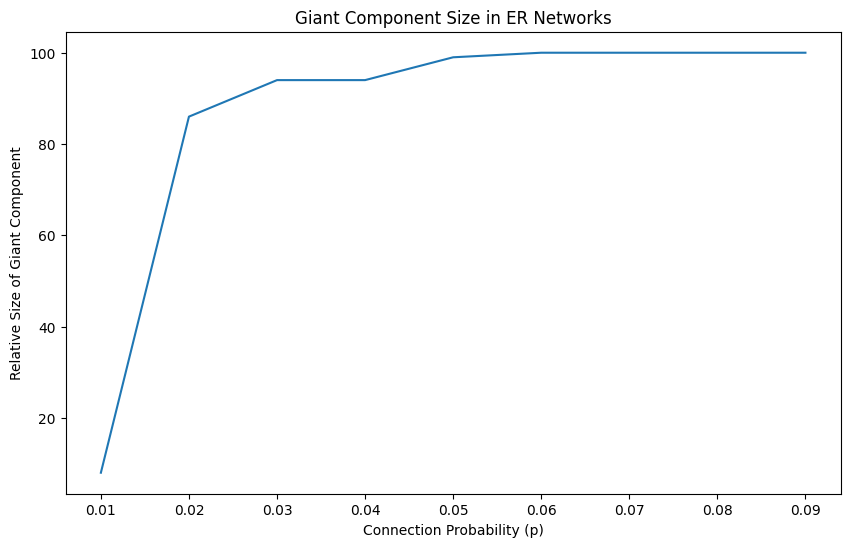

In [23]:
def er_giant_component_size(N=100, ensemble=100):
  p_values = np.arange(0.01, 0.1, 0.01)
  giant_sizes = []

  for p in p_values:
    sizes = 0
    G = ER_Graph(N, p)
    for _ in range(ensemble):
      largest_cc = max(nx.connected_components(G), key=len)
      sizes += len(largest_cc)
    giant_sizes.append(sizes/ensemble)

  plt.figure(figsize=(10, 6))
  plt.plot(p_values, giant_sizes)
  plt.xlabel('Connection Probability (p)')
  plt.ylabel('Relative Size of Giant Component')
  plt.title('Giant Component Size in ER Networks')
  plt.show()

er_giant_component_size()